In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
device="cuda:0"
import torch
import datasets
import io
from types import SimpleNamespace
from codec import AutoEncoderND
from torchvision.transforms.v2 import Compose, CenterCrop, ToTensor, Normalize, ToPILImage

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
config = SimpleNamespace()
config.resolution = 512
config.codec_checkpoint = "../hf/dance/LF_rgb_f16c12_v1.0.pth"

In [3]:
checkpoint = torch.load(config.codec_checkpoint, map_location=device, weights_only=False)
codec_config = checkpoint['config']
state_dict = checkpoint['state_dict']

codec = AutoEncoderND(
    dim=2,
    input_channels=codec_config.input_channels,
    J=int(codec_config.F**0.5),
    latent_dim=codec_config.latent_dim,
    lightweight_encode=codec_config.lightweight_encode,
    lightweight_decode=codec_config.lightweight_decode
).to(device)
codec.load_state_dict(state_dict)
codec.eval();

In [ ]:
dataset = datasets.load_dataset("danjacobellis/LSDIR_540",split='train')

transform = Compose([
    CenterCrop(config.resolution),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def gen_conditioning_img(sample):
    x = transform(sample['image']).to(device).unsqueeze(0)
    img = ToPILImage()(x[0]/2 + 0.5)
    buff = io.BytesIO()
    img.save(buff, format='WEBP', lossless=True)
    webp_bytes = buff.getbuffer()

    with torch.no_grad():
        xhat = codec.decode(codec.quantize.compand(codec.encode(x)).round()).clamp(-1,1)

    img2 = ToPILImage()(xhat[0]/2 + 0.5)
    buff2 = io.BytesIO()
    img2.save(buff2, format='WEBP', lossless=True)
    webp_bytes2 = buff2.getbuffer()
    return {
        'image': webp_bytes,
        'conditioning_image': webp_bytes2
    }

new_dataset = dataset.map(gen_conditioning_img,writer_batch_size=500).cast_column('image',datasets.Image()).cast_column('conditioning_image',datasets.Image())

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/85 [00:00<?, ?it/s]

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Map:   0%|          | 0/84991 [00:00<?, ? examples/s]

In [ ]:
new_dataset.push_to_hub("danjacobellis/LSDIR_512_f16c12", split='train')

---

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/refs/heads/main/examples/controlnet/train_controlnet_flux.py

In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
device = "cuda:0"

import os
import torch
import datasets
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from PIL import Image
from datasets import load_dataset

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [4]:
# Cell 2: Configuration
config = SimpleNamespace()
config.pretrained_model_name_or_path = "black-forest-labs/FLUX.1-dev"  # Base FLUX model
config.dataset_name = "danjacobellis/LSDIR_512_f16c12"  # Pre-computed dataset
config.output_dir = "controlnet_enhancer"  # Where to save the model
config.resolution = 160  # Matches dataset resolution
config.train_batch_size = 4  # Recommended for 80GB A100
config.gradient_accumulation_steps = 1  # Adjusted for batch size 2
config.learning_rate = 1e-5  # From tutorial
config.max_train_steps = 21250  # Total training steps
config.validation_steps = 100  # Validate every 100 steps
config.checkpointing_steps = 200  # Save checkpoint every 200 steps
config.num_double_layers = 4  # ControlNet architecture
config.num_single_layers = 0  # ControlNet architecture
config.seed = 42  # For reproducibility
config.report_to = "tensorboard"  # Logging
config.mixed_precision = "bf16"  # Use float32 as requested
config.allow_tf32 = True  # Speed up on A100
config.max_train_samples = None  # Use full dataset; set to 1000 for testing
config.checkpoints_total_limit = 3  # Keep only 3 checkpoints

In [ ]:
# dataset = load_dataset(config.dataset_name, split="train")
# fixed_prompt = "a high-quality photograph"  # Generic prompt for enhancement
# dataset = dataset.map(lambda x: {"text": fixed_prompt})
# dataset.push_to_hub("danjacobellis/LSDIR_512_f16c12_caption",split='train')
# val_samples = dataset.select([0, 1])  # Take first two samples for validation
# os.makedirs("validation_images", exist_ok=True)
# for i, sample in enumerate(val_samples):
#     cond_img = sample["conditioning_image"]  # Codec-decoded image
#     cond_img.save(f"validation_images/cond_{i}.png")

In [8]:
# Cell 4: Training Command
training_command = f"""
CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8 accelerate launch train_controlnet_flux.py \
    --pretrained_model_name_or_path="{config.pretrained_model_name_or_path}" \
    --dataset_name="danjacobellis/LSDIR_512_f16c12_caption" \
    --conditioning_image_column="conditioning_image" \
    --image_column="image" \
    --caption_column="text" \
    --output_dir="{config.output_dir}" \
    --mixed_precision="{config.mixed_precision}" \
    --resolution={config.resolution} \
    --learning_rate={config.learning_rate} \
    --max_train_steps={config.max_train_steps} \
    --validation_steps={config.validation_steps} \
    --checkpointing_steps={config.checkpointing_steps} \
    --train_batch_size={config.train_batch_size} \
    --gradient_accumulation_steps={config.gradient_accumulation_steps} \
    --report_to="{config.report_to}" \
    --num_double_layers={config.num_double_layers} \
    --num_single_layers={config.num_single_layers} \
    --seed={config.seed} \
    --allow_tf32 \
    --checkpoints_total_limit={config.checkpoints_total_limit}
"""

# Execute the training command
print("Running training command:")
print(training_command)

Running training command:

CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8 accelerate launch train_controlnet_flux.py     --pretrained_model_name_or_path="black-forest-labs/FLUX.1-dev"     --dataset_name="danjacobellis/LSDIR_512_f16c12_caption"     --conditioning_image_column="conditioning_image"     --image_column="image"     --caption_column="text"     --output_dir="controlnet_enhancer"     --mixed_precision="bf16"     --resolution=160     --learning_rate=1e-05     --max_train_steps=21250     --validation_steps=100     --checkpointing_steps=200     --train_batch_size=4     --gradient_accumulation_steps=1     --report_to="tensorboard"     --num_double_layers=4     --num_single_layers=0     --seed=42     --allow_tf32     --checkpoints_total_limit=3



---

In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
device="cuda:0"
import torch
from diffusers.utils import load_image
from diffusers import FluxControlNetModel
from diffusers.pipelines import FluxControlNetPipeline
controlnet = FluxControlNetModel.from_pretrained(
    "controlnet_enhancer",
    torch_dtype=torch.float32
)
# controlnet = FluxControlNetModel.from_pretrained(
#   "jasperai/Flux.1-dev-Controlnet-Upscaler",
#   torch_dtype=torch.bfloat16
# )
pipe = FluxControlNetPipeline.from_pretrained(
  "black-forest-labs/FLUX.1-dev",
  controlnet=controlnet,
  torch_dtype=torch.float32
).to("cuda")

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [2]:
control_image = load_image(
  "compressed.png"
)
w, h = control_image.size
control_image = control_image.resize((w * 2, h * 2))

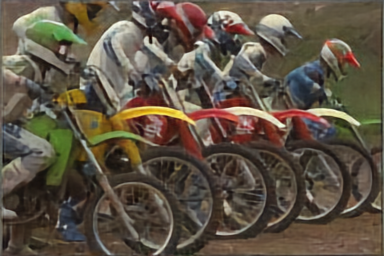

In [9]:
control_image.resize((w//2,h//2))

  0%|          | 0/28 [00:00<?, ?it/s]

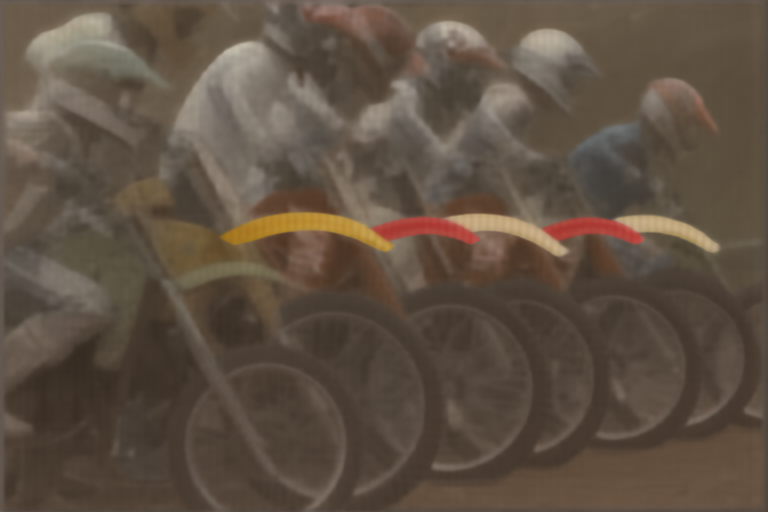

In [4]:
image = pipe(
    prompt="", 
    control_image=control_image,
    controlnet_conditioning_scale=0.6,
    num_inference_steps=28, 
    guidance_scale=3.5,
    height=control_image.size[1],
    width=control_image.size[0]
).images[0].resize((w,h))
image

  0%|          | 0/56 [00:00<?, ?it/s]

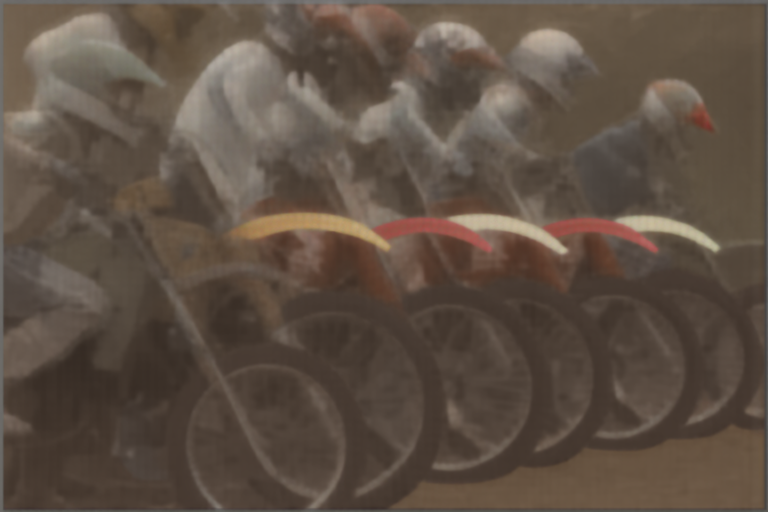

In [5]:
image = pipe(
    prompt="", 
    control_image=control_image,
    controlnet_conditioning_scale=0.6,
    num_inference_steps=56, 
    guidance_scale=3.5,
    height=control_image.size[1],
    width=control_image.size[0]
).images[0].resize((w,h))
image